## **Using** **SVM**

In [ ]:
import os
import zipfile
import urllib.request
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
!pip install soundata
!pip install soundata --quiet
import soundata
dataset_folder = "UrbanSound8K"

def download_and_extract_dataset():
    print("Initializing UrbanSound8K dataset with soundata...")
    dataset = soundata.initialize('urbansound8k', data_home=dataset_folder)

    if not os.path.exists(dataset_folder):
        print("Downloading UrbanSound8K dataset...")
        dataset.download()
        print("Download complete.")
    else:
        print("Dataset already exists. Skipping download.")

    return dataset

dataset = download_and_extract_dataset()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 37.3 MB/s eta 0:00:00
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64901 sha256=db8d9b2fa7a9dce8659591c35a25e028ff6749e0bc9b5e

5.61GB [08:36, 11.7MB/s]                            
1.15MB [00:01, 727kB/s]                             

Download complete.


In [ ]:
def load_audio(file_path, sr=22050):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

In [ ]:
def compute_spectrogram(y, sr, window_type, n_fft=2048, hop_length=512):
    window = get_window(window_type, n_fft)
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
    spectrogram = np.abs(stft)
    return spectrogram

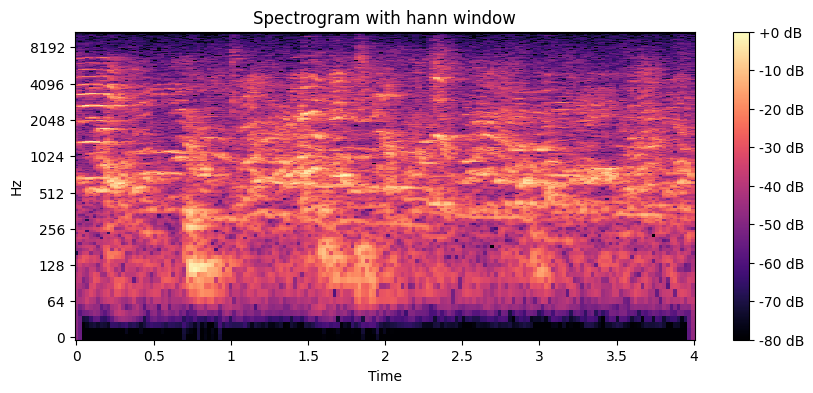

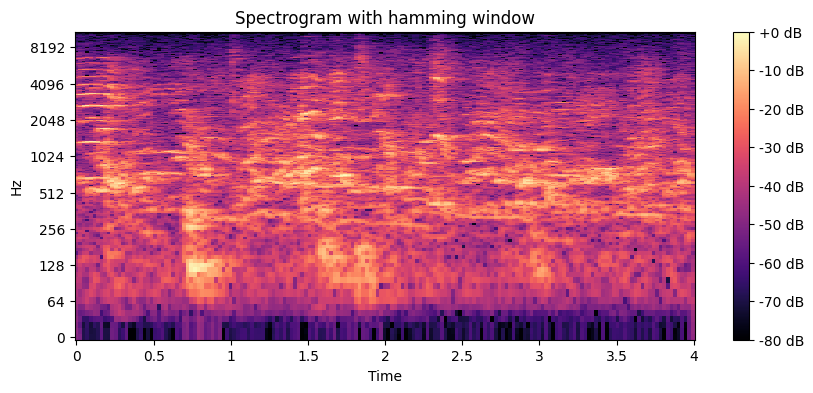

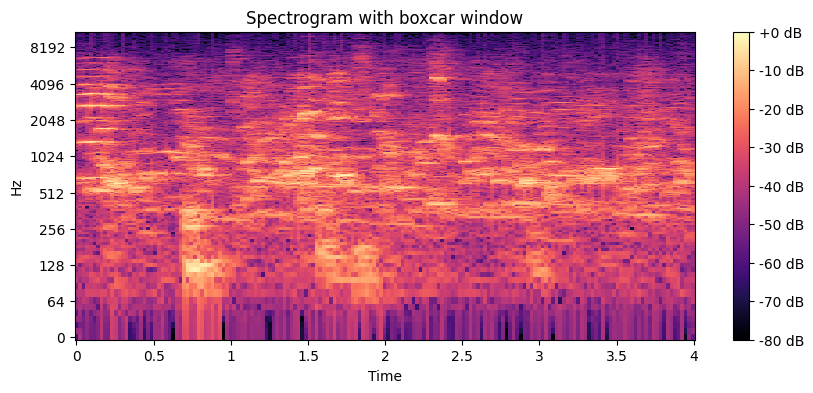

In [ ]:
def plot_spectrogram(spectrogram, title, sr, hop_length):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max),
                             sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

clip_ids = dataset.clip_ids
sample_clip = dataset.clip(clip_ids[0])
sample_file = sample_clip.audio_path

y, sr = load_audio(sample_file)

windows = ["hann", "hamming", "boxcar"]
for win in windows:
    spectrogram = compute_spectrogram(y, sr, window_type=win)
    plot_spectrogram(spectrogram, f"Spectrogram with {win} window", sr, hop_length=512)

In [ ]:
def extract_features(y, sr, window_type, n_mfcc=13):
    spectrogram = compute_spectrogram(y, sr, window_type)
    mfccs = librosa.feature.mfcc(S=spectrogram, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs, axis=1)

X = []
y_labels = []
window_types = ["hann", "hamming", "boxcar"]

for clip_id in dataset.clip_ids[:100]:
    clip = dataset.clip(clip_id)
    file_path = clip.audio_path
    label = clip.tags.labels[0] if clip.tags.labels else 0

    y_audio, sr_audio = load_audio(file_path)

    for win in window_types:
        features = extract_features(y_audio, sr_audio, window_type=win)
        X.append(features)
        y_labels.append(label)

X = np.array(X)
y_labels = np.array(y_labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7333333333333333
                  precision    recall  f1-score   support

 air_conditioner       1.00      1.00      1.00         5
children_playing       0.33      0.40      0.36         5
        dog_bark       0.00      0.00      0.00         3
        drilling       1.00      1.00      1.00         4
   engine_idling       0.60      0.60      0.60         5
        gun_shot       1.00      0.33      0.50         3
      jackhammer       1.00      0.96      0.98        23
           siren       0.55      1.00      0.71         6
    street_music       1.00      0.17      0.29         6

        accuracy                           0.73        60
       macro avg       0.72      0.61      0.60        60
    weighted avg       0.82      0.73      0.73        60



## **Using** **CNN**

Initializing UrbanSound8K dataset with soundata...
Dataset already exists. Skipping download.
📌 Automatically set max_time_frames to: 87


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 2047, 85, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 2047, 85, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 1023, 42, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 1021, 40, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 1021, 40, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 510, 20, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 508, 18, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 508, 18, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 254, 9, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 292608)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │      74,907,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,005,066 (286.12 MB)

 Trainable params: 75,004,106 (286.12 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.4742 - loss: 1.8791 - val_accuracy: 0.0667 - val_loss: 2.7933 - learning_rate: 5.0000e-04
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.8089 - loss: 0.6430 - val_accuracy: 0.0667 - val_loss: 3.2517 - learning_rate: 5.0000e-04
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.8864 - loss: 0.4819 - val_accuracy: 0.0667 - val_loss: 3.0477 - learning_rate: 5.0000e-04
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.8781 - loss: 0.3995 - val_accuracy: 0.1167 - val_loss: 2.6448 - learning_rate: 5.0000e-04
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.9122 - loss: 0.3006 - val_accuracy: 0.1167 - val_loss: 3.1996 - learning_rate: 5.0000e-04
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.8971 - loss: 0.3780 - val_accuracy: 0.1222 - val_loss: 3.4878 - learning_rate: 5.0000e-04
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accura

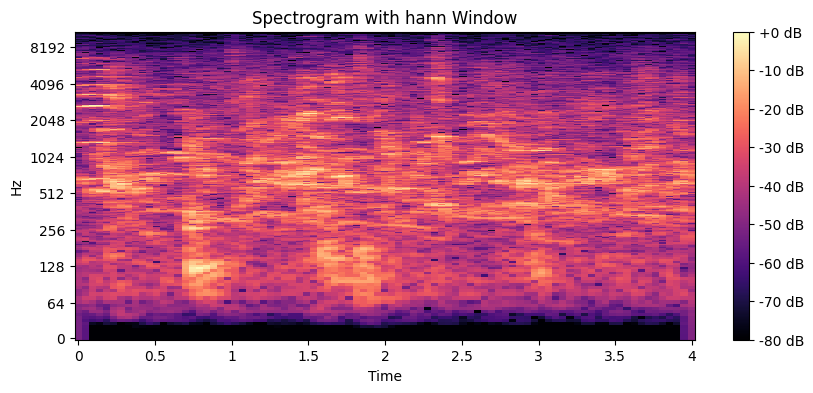

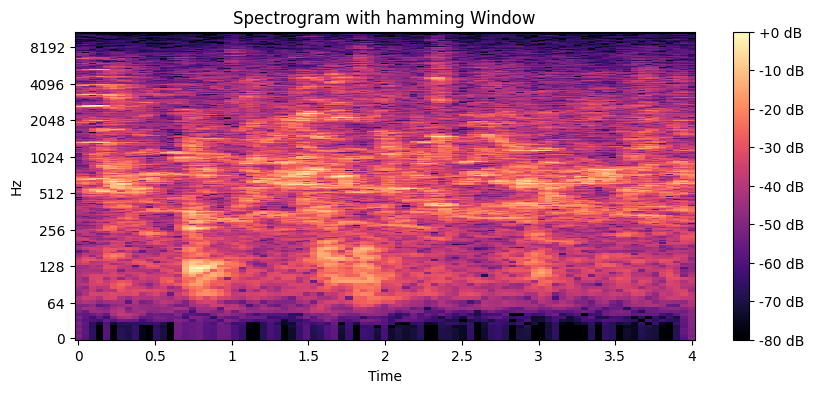

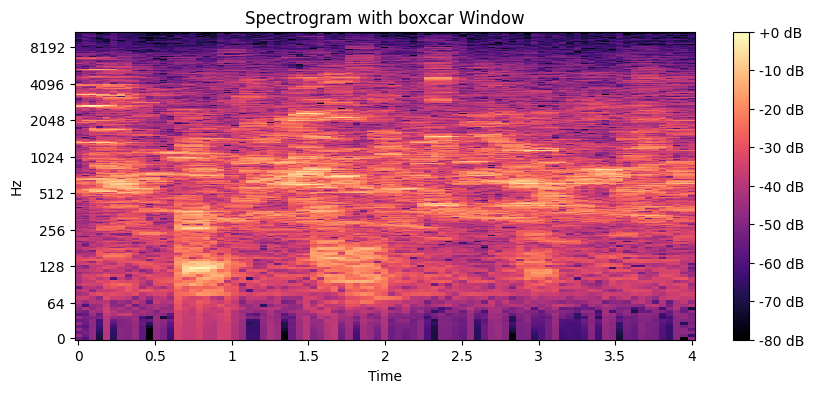

In [ ]:
import librosa
import librosa.display
import soundata
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.signal import get_window

dataset_folder = "UrbanSound8K"

def download_and_extract_dataset():
    print("Initializing UrbanSound8K dataset with soundata...")
    dataset = soundata.initialize('urbansound8k', data_home=dataset_folder)

    if not os.path.exists(dataset_folder):
        print("Downloading UrbanSound8K dataset...")
        dataset.download()
        print("Download complete.")
    else:
        print("Dataset already exists. Skipping download.")

    return dataset

dataset = download_and_extract_dataset()

def load_audio(file_path, sr=22050):
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

n_fft = 4096

def compute_spectrogram(y, sr, window_type, hop_length=None):
    """Computes STFT-based spectrogram using a given windowing technique and adjusts time-frame dynamically."""

    if hop_length is None:
        hop_length = n_fft // 4

    window = get_window(window_type, n_fft)
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
    spectrogram = np.abs(stft)

    return spectrogram

all_time_frames = []

for clip_id in dataset.clip_ids[:300]:
    clip = dataset.clip(clip_id)
    file_path = clip.audio_path
    y_audio, sr_audio = load_audio(file_path)

    for win in ["hann", "hamming", "boxcar"]:
        spectrogram = compute_spectrogram(y_audio, sr_audio, window_type=win)
        all_time_frames.append(spectrogram.shape[1])

max_time_frames = min(max(all_time_frames), 200)

print(f"📌 Automatically set max_time_frames to: {max_time_frames}")

X = []
y_labels = []
window_types = ["hann", "hamming", "boxcar"]

for clip_id in dataset.clip_ids[:300]:
    clip = dataset.clip(clip_id)
    file_path = clip.audio_path
    label = clip.tags.labels[0] if clip.tags.labels else "unknown"

    y_audio, sr_audio = load_audio(file_path)

    for win in window_types:
        spectrogram = compute_spectrogram(y_audio, sr_audio, window_type=win)

        if spectrogram.shape[1] < max_time_frames:
            pad_width = max_time_frames - spectrogram.shape[1]
            spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
        else:
            spectrogram = spectrogram[:, :max_time_frames]

        X.append(spectrogram)
        y_labels.append(label)

X = np.array(X)
y_labels = np.array(y_labels)

X = X / np.max(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
y_categorical = to_categorical(y_encoded)

X = X[..., np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

cnn_model = build_cnn_model(input_shape=X_train.shape[1:], num_classes=y_categorical.shape[1])
cnn_model.summary()

cnn_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), callbacks=[reduce_lr])

test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

def plot_spectrogram(spectrogram, title, sr, hop_length):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.amplitude_to_db(spectrogram + 1e-10, ref=np.max),  # ✅ Fix colors
                             sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

file_path = dataset.clip(dataset.clip_ids[0]).audio_path  # Select an example file
y, sr = load_audio(file_path)

for win in window_types:
    spectrogram = compute_spectrogram(y, sr, window_type=win)
    plot_spectrogram(spectrogram, f"Spectrogram with {win} Window", sr, hop_length=n_fft // 4)